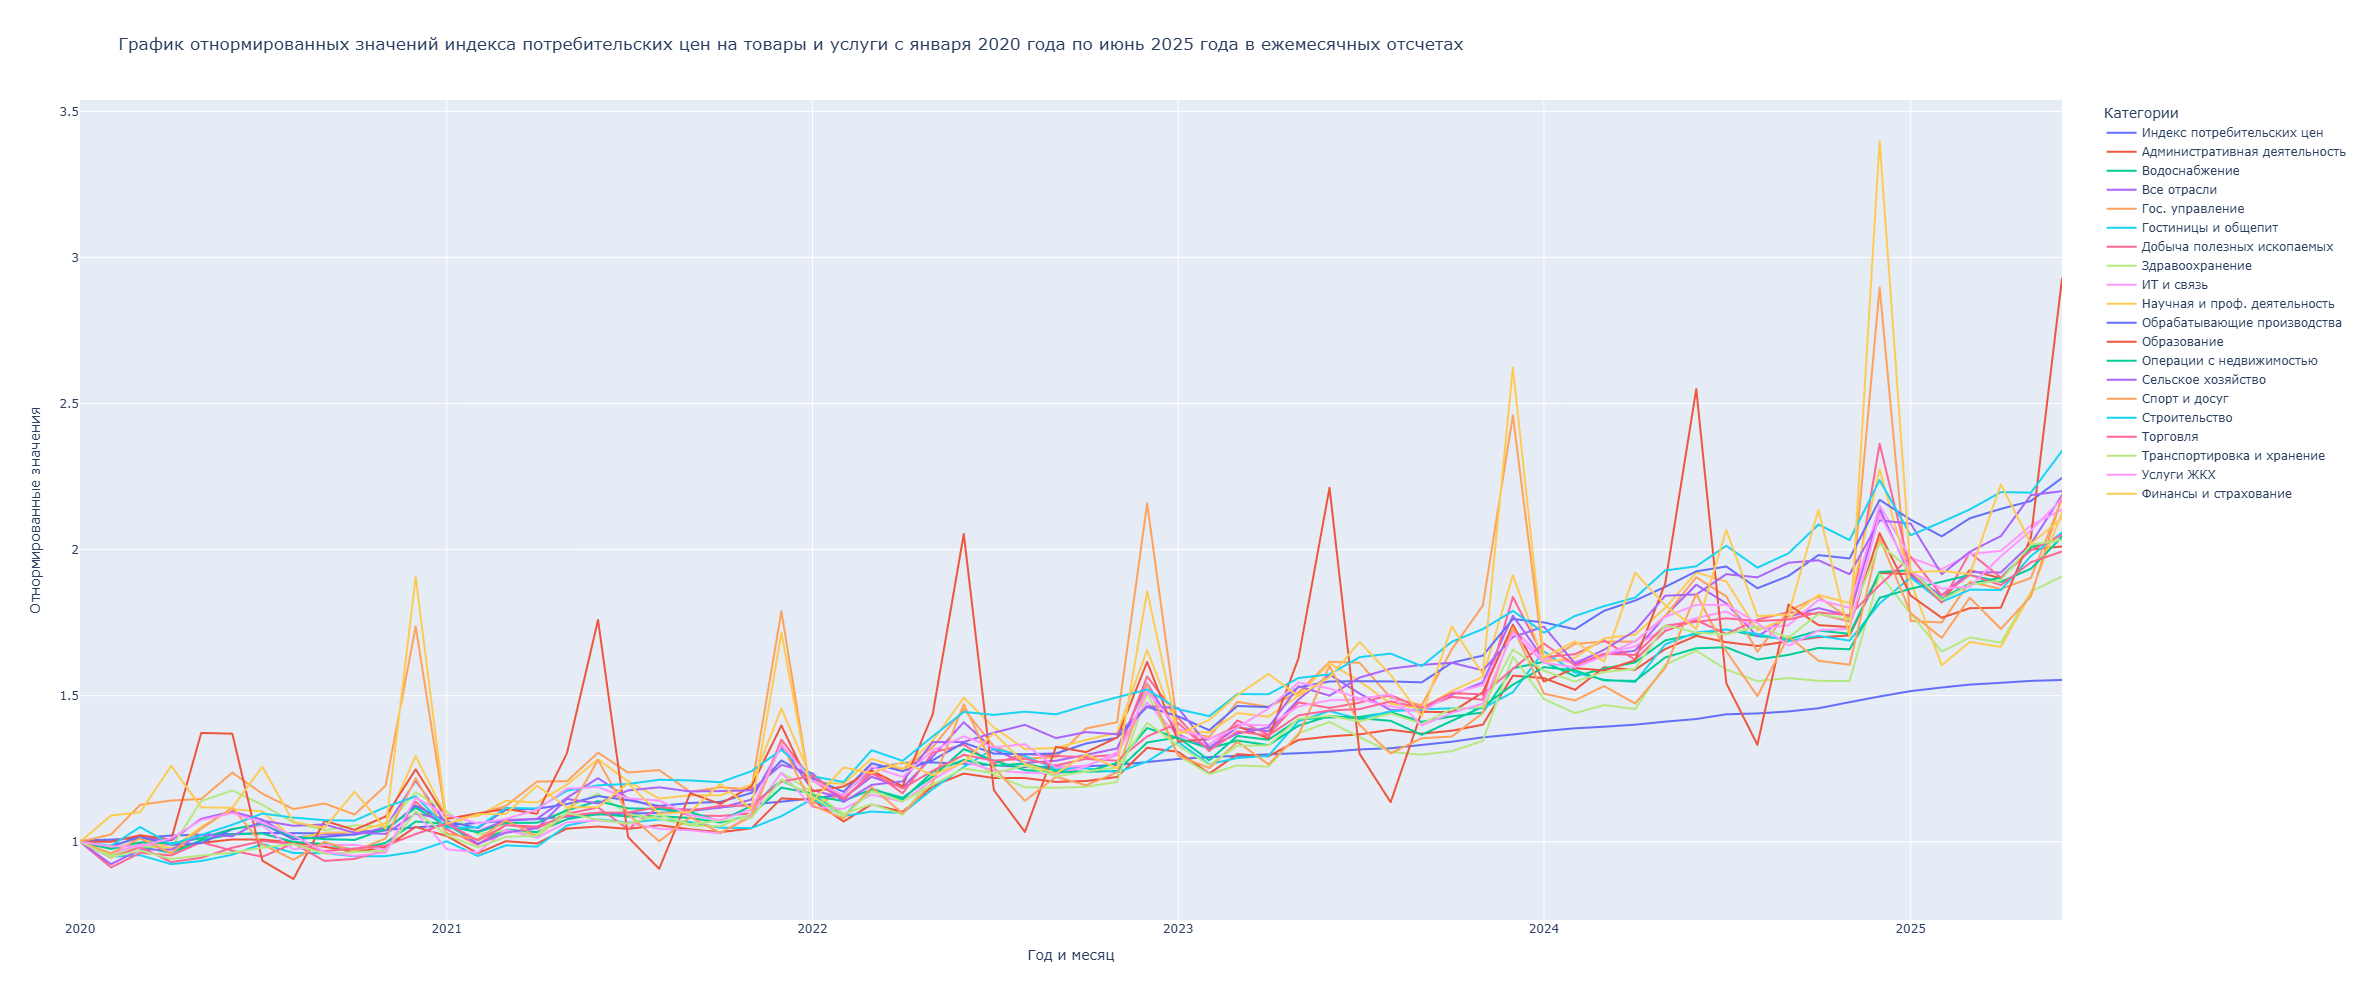

In [3]:
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
import pprint
import plotly.express as px

# Функции нижнего уровня
def excel_to_df(file_name, sheet_name, start_row, start_col, n_row, n_col, head_row, head_col,data_schema):
    """
    Функция считывает указанную область из Excel и формирует вертикальный Spark DataFrame.
    
    :param file_path: путь к файлу Excel
    :param sheet_name: название листа
    :param start_row: номер начальной строки (начиная с 0)
    :param start_col: номер начального столбца (начиная с 0)
    :n_row: количество читаемых строк для тела таблицы. Будут прочитаны строки со смещением от 0 до n_row-1
    :n_col: количество читаемых колонок для тела таблицы. Будут прочитаны колонки со смещенем от 0 до n_col-1
    :head_row: номер строки, в которой находятся заголовки колонок
    :head_col: номер колонки, в которой находтся заголовки строк. В текущей версии не используется.
    """
    # Чтение всего листа целиком с помощью Pandas
    full_sheet_pd = pd.read_excel(file_name, sheet_name=sheet_name, header=None)
    
    data_list = []
    for c in range(n_col):
        for r in range(n_row):
            if str(full_sheet_pd.iloc[start_row+r,start_col+c]) == "nan":
                break
            data_item = (str(int(full_sheet_pd.iloc[head_row,start_col+c])), str(r+1), str(full_sheet_pd.iloc[start_row+r,start_col+c]))  # Год, номер месяца, величина. Номер месяца сознантельно сделан из индекса, чтобы не преобразывать из названия.
            # print(data_item)
            data_list.append(data_item)
    # print(data_list)
    df = spark.createDataFrame(data = data_list, schema = data_schema)
    return df

def csv_to_df(file_name, schema, delimiter, encoding):
    df = spark.read.option('header','True').option('delimiter',delimiter).option("encoding",encoding).csv(file_name)
    return df

# Функции промежуточного уровня
def load_price_index():
    file_name = 'ipc_mes_07-2025.xlsx'  # Имя файлу
    sheet_name = '01'                   # Название листа
    start_row = 5
    start_col = 1
    n_row = 12
    n_col = 35
    head_row = 3
    head_col = 0
    data_schema = ["year","month","value"]
    
    price_index_df = excel_to_df(file_name, sheet_name, start_row, start_col,n_row,n_col,head_row,head_col,data_schema)
    # price_index_df.show(10,0)
    return price_index_df

def load_median_wages():
    file_name = 'median-wages.csv'
    data_schema = ["date","category","value"]
    delimiter =";"
    encoding = "windows-1251"

    median_wages_df = csv_to_df(file_name, data_schema, delimiter, encoding)
    # median_wages_df.show(10,0)
    return median_wages_df

# Основаня обработка и соединение данных из разных источников
def processing():
    spark.catalog.dropTempView("t_price_index")
    spark.catalog.dropTempView("t_median_wages")
    load_price_index().createTempView("t_price_index")
    load_median_wages().createTempView("t_median_wages")
    result_df = spark.sql("""
    WITH tpi AS (
      SELECT CONCAT(year,"-",lpad(month,2,'0')) AS ym, value, ROUND(EXP(SUM(LOG(CAST(value AS DECIMAL(38,18)) /100)) OVER (ORDER BY CONCAT(year,"-",lpad(month,2,'0')))), 6) AS cum_price_index_value 
      FROM t_price_index
      WHERE CONCAT(year,"-",lpad(month,2,'0')) between '2020-01' and '2025-06'
    ), tmw as (
      SELECT SUBSTRING(date,1,7) AS ym, category, value AS wages_value, ROUND(value / FIRST_VALUE(value) OVER(PARTITION BY category ORDER BY SUBSTRING(date,1,7)), 6) AS rel_val
      FROM t_median_wages
      WHERE SUBSTRING(date,1,7) between '2020-01' and '2025-06'
    )
    (
    SELECT ym, 0 as base, "Индекс потребительских цен" AS category, cum_price_index_value AS value
    FROM tpi
    UNION ALL
    SELECT ym, 1 as base, category, rel_val AS value
    FROM tmw
    )
    ORDER BY ym, base, category
    """)
    # result_df.show(10,0)
    spark.catalog.dropTempView("t_price_index")
    spark.catalog.dropTempView("t_median_wages")
    return result_df

# функция построения графиков по подготовленному датафрейму
def plot_graphs(df):
    pdf = df.toPandas()
    fig = px.line(pdf, x='ym', y='value', color='category',
              title='График отнормированных значений индекса потребительских цен на товары и услуги с января 2020 года по июнь 2025 года в ежемесячных отсчетах',
              labels={
                  'ym': 'Год и месяц',
                  'value': 'Отнормированные значения',
                  'category': 'Категории'
              })
    fig.update_layout(height=1000)
    fig.show()


if __name__ == "__main__":
    spark = SparkSession.builder.appName("project_application").config('spark.driver.log.level', 'ERROR').getOrCreate()
    sc = spark.sparkContext
    sc.setLogLevel('ERROR')
    
    processed_df = processing()
    plot_graphs(processed_df)

    spark.stop()